<a href="https://colab.research.google.com/github/PDBeurope/pdbe-api-training/blob/master/PDB_release_stats.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

1) Making imports and setting variables
First, we import some packages that we will use, and set some variables.

Note: Full list of valid URLs is available from https://www.ebi.ac.uk/pdbe/api/doc/

In [1]:
import requests # used for getting data from a URL
from pprint import pprint # pretty print
import pandas as pd # used for turning results into mini databases
!pip install solrq
from solrq import Q # used to turn result queries into the right format
import numpy as np
import datetime
today = datetime.date.today()
year = today.year

search_url = "https://www.ebi.ac.uk/pdbe/search/pdb/select?" # the rest of the URL used for PDBe's search API.



Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


2) a function to get data from the search API
Let's start with defining a function that can be used to GET data from the PDBe search API.

In [2]:
def make_request(search_dict, number_of_rows=10, group_pdb=False):
    """
    makes a get request to the PDBe API
    :param dict search_dict: the terms used to search
    :param number_of_rows: number or rows to return - limited to 10
    :return dict: response JSON
    """
    if 'rows' not in search_dict:
        search_dict['rows'] = number_of_rows
    search_dict['wt'] = 'json'
    if group_pdb == True:
      search_dict['group'] = 'true'
      search_dict['group.field'] = 'pdb_id'
      search_dict['group.ngroups'] = 'true'
    response = requests.post(search_url, data=search_dict)

    if response.status_code == 200:
        return response.json()
    else:
        print("[No data retrieved - %s] %s" % (response.status_code, response.text))

    return {}

3) formatting the search terms
This will allow us to use human readable search terms and this function will make a URL that the search API can handle.

In [3]:
def format_search_terms(search_terms, filter_terms=None):
    ret = {'q': str(search_terms)}
    if filter_terms:
        fl = '{}'.format(','.join(filter_terms))
        ret['fl'] = fl
    return ret

4) Getting useful data out of the search
This function will run the search and will return a list of the results

In [4]:
def run_search(search_terms, filter_terms=None, number_of_rows=100, group_pdb=False):
    search_term = format_search_terms(search_terms, filter_terms)
    response = make_request(search_term, number_of_rows, group_pdb)
    results = response.get('response', {}).get('docs', [])
    return results

In [5]:
def run_grouped_search(search_terms, filter_terms=None, number_of_rows=100, group_pdb=True):
    search_term = format_search_terms(search_terms, filter_terms)
    response = make_request(search_term, number_of_rows, group_pdb)
    preresults = response.get('grouped', {}).get('pdb_id', {}).get('groups', [])
    results = []
    for group in preresults:
      docs = group.get('doclist', {}).get('docs', [])
      for doc in docs:
        results.append(doc)
    return results

Search for entries by year:

In [7]:
search_terms = Q(status="REL")
filter_terms = ['pdb_id', 'experimental_method', 'release_year', 'resolution', 'em_resolution', 'assembly_mol_wt', 'journal', 'refinement_software', 'synchrotron_site', 'em_electron_detection', 'cath_homologous_superfamily', 'assembly_composition', 'processing_site']
#all_results = run_search(search_terms, filter_terms, number_of_rows=100, group_pdb=False)
all_results = run_grouped_search(search_terms, filter_terms, number_of_rows=220000, group_pdb=True)

{'fl': 'pdb_id,experimental_method,release_year,resolution,em_resolution,assembly_mol_wt,journal,refinement_software,synchrotron_site,em_electron_detection,cath_homologous_superfamily,assembly_composition,processing_site',
 'group': 'true',
 'group.field': 'pdb_id',
 'group.ngroups': 'true',
 'q': 'status:REL',
 'rows': 220000,
 'wt': 'json'}
'https://www.ebi.ac.uk/pdbe/search/pdb/select?'
Number of results: 200069


6) Analysing and plotting the results
We are going to use a Python package called Pandas to help us sort and visualise the results

First we have to do a bit of housekeeping, some of the results are lists (a PDB entry can have more than one experimental method or organism for example) so we need to change them into strings so we can use them in a graph

In [8]:
def change_lists_to_strings(results):
    """
    input - list of results from search
    output - list of results with lists changed into strings
    """
    for row in results:
        for data in row:
            if type(row[data]) == list:
                # if there are any numbers in the list change them into strings
                row[data] = [str(a) for a in row[data]]
                # unique and sort the list and then change the list into a string
                row[data] = ','.join(sorted(list(set(row[data]))))
                
    return results

In [9]:
results = change_lists_to_strings(all_results)

Notice that the only thing that changed is ['X-ray diffraction'] is now 'X-ray diffraction'

If we wanted to know the experimental methods used to determine structures of Human Dihydrofolate reductase we could loop through the results and count how many entries use each experimental method.

We can use a Python package called Pandas to do this for us. It changes the results into a mini database - called a DataFrame.

In [10]:
def pandas_dataset(list_of_results):
    results = change_lists_to_strings(list_of_results) # we have added our function to change lists to strings
    df = pd.DataFrame(results)

    return df

df = pandas_dataset(list_of_results=results)
print(df)

           assembly_composition  assembly_mol_wt  \
0             protein structure           18.964   
1             protein structure           21.155   
2             protein structure           18.175   
3       protein/protein complex          247.373   
4             protein structure           80.061   
...                         ...              ...   
200064        protein structure           30.581   
200065        protein structure           22.811   
200066        protein structure           36.315   
200067        protein structure          121.094   
200068  protein/protein complex           31.722   

                              cath_homologous_superfamily experimental_method  \
0                                                Lysozyme   X-ray diffraction   
1                                            Glutaredoxin        Solution NMR   
2                            Ubiquitin Conjugating Enzyme   X-ray diffraction   
3                              Urease, gamma-like s

**Total releases by experimental method**

We can use the this to count how many PDB codes there are for each experimental method This groups PDB IDs by experimental method and then counts the number of unique PDB IDs per method.

In [11]:
ds = df.groupby('experimental_method')['pdb_id'].nunique()
print(ds)

experimental_method
EPR,Hybrid,Solution NMR                                                      1
EPR,Hybrid,X-ray diffraction                                                 7
Electron Microscopy                                                      13623
Electron Microscopy,Hybrid,Solid-state NMR                                   9
Electron Microscopy,Hybrid,Solid-state NMR,Solution NMR                      1
Electron Microscopy,Hybrid,Solid-state NMR,X-ray solution scattering         1
Electron Microscopy,Hybrid,Solution NMR                                      2
Electron Microscopy,Hybrid,X-ray solution scattering                         2
Electron crystallography                                                   219
Fiber diffraction                                                           29
Fiber diffraction,Hybrid,Solid-state NMR                                     1
Fluorescence transfer                                                        1
Hybrid,Neutron Diffraction,Solut

We will make this into two functions so we can use them again

In [22]:
def pandas_count(list_of_results, column_to_group_by):
    df = pandas_dataset(list_of_results)
    ds = df.groupby(column_to_group_by)['pdb_id'].nunique()
    return ds
    
def pandas_min_max(list_of_results, column_to_group_by, get_min=True):
    df = pandas_dataset(list_of_results)
    if get_min:
        ds = df.groupby(column_to_group_by)['pdb_id'].min()
    else:
        ds = df.groupby(column_to_group_by)['pdb_id'].max()
    return ds
    
def pandas_plot(list_of_results, column_to_group_by, graph_type='bar'):
    ds = pandas_count(list_of_results=list_of_results, column_to_group_by=column_to_group_by)
    ds.plot(kind=graph_type, figsize=(8,5))

def pandas_mean_plot(list_of_results, column_to_group_by, graph_type='bar'):
    df = pandas_dataset(list_of_results)
    df.groupby(column_to_group_by).mean().plot(kind=graph_type, figsize=(8,5))

def pandas_plot_binned(list_of_results, column_to_group_by, bin_cat, bin_range, graph_type='bar'):
    df = pandas_dataset(list_of_results)
    df[bin_cat] = pd.cut(df[column_to_group_by],bin_range)
    ds = df.groupby(bin_cat)
    ds.plot(kind=graph_type, figsize=(8,5))


In [23]:
pandas_count(list_of_results=results, column_to_group_by='experimental_method')

experimental_method
EPR,Hybrid,Solution NMR                                                      1
EPR,Hybrid,X-ray diffraction                                                 7
Electron Microscopy                                                      13623
Electron Microscopy,Hybrid,Solid-state NMR                                   9
Electron Microscopy,Hybrid,Solid-state NMR,Solution NMR                      1
Electron Microscopy,Hybrid,Solid-state NMR,X-ray solution scattering         1
Electron Microscopy,Hybrid,Solution NMR                                      2
Electron Microscopy,Hybrid,X-ray solution scattering                         2
Electron crystallography                                                   219
Fiber diffraction                                                           29
Fiber diffraction,Hybrid,Solid-state NMR                                     1
Fluorescence transfer                                                        1
Hybrid,Neutron Diffraction,Solut

**Total releases by year**

We can use the this to count how many PDB codes there are for each experimental method This groups PDB IDs by experimental method and then counts the number of unique PDB IDs per method.

In [24]:
pandas_count(list_of_results=results, column_to_group_by='release_year')

release_year
1976       13
1977       23
1978        6
1979       11
1980       16
1981       16
1982       32
1983       36
1984       22
1985       20
1986       18
1987       25
1988       53
1989       74
1990      142
1991      187
1992      192
1993      696
1994     1289
1995      941
1996     1172
1997     1564
1998     2056
1999     2356
2000     2627
2001     2813
2002     2994
2003     4147
2004     5149
2005     5334
2006     6407
2007     7134
2008     6903
2009     7289
2010     7745
2011     7927
2012     8755
2013     9339
2014     9562
2015     9252
2016    10814
2017    11065
2018    11168
2019    11495
2020    13997
2021    12587
2022    14292
2023      314
Name: pdb_id, dtype: int64

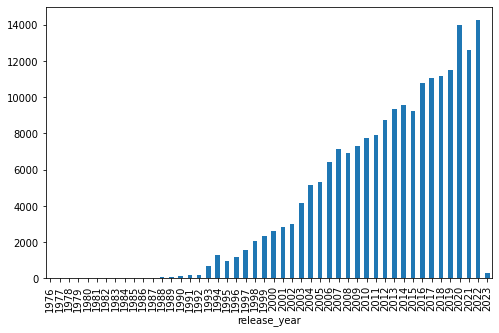

In [25]:
pandas_plot(list_of_results=results, column_to_group_by='release_year')

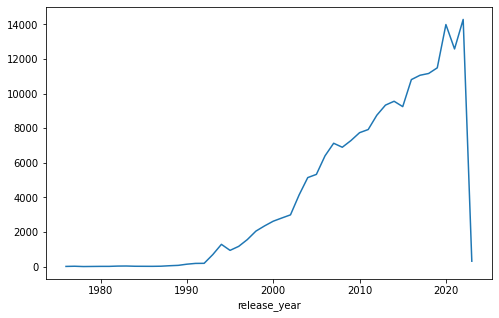

In [26]:
pandas_plot(list_of_results=results, column_to_group_by='release_year', graph_type='line')

In [27]:
def pandas_plot_multi_groupby(results, first_column_to_group_by, second_column_to_group_by, y_axis='pdb_id', graph_type='line', first_range_flag=False, first_lower=1971, first_upper=year):
    
    df = pandas_dataset(results)
    if first_range_flag:
      df = df[df[first_column_to_group_by].between(first_lower, first_upper)]
    new_df = df.groupby([first_column_to_group_by, second_column_to_group_by])
    ds = new_df.count().unstack().reset_index(first_column_to_group_by)
    ds.plot(x=first_column_to_group_by, y=y_axis, kind=graph_type,figsize=(8,5)).legend(bbox_to_anchor=(1,1))
    
def pandas_plot_multi_groupby_filter(results, first_column_to_group_by, second_column_to_group_by, filter_column, filter_list, y_axis='pdb_id', graph_type='line', first_range_flag=False, first_lower=1971, first_upper=year):
    
    df = pandas_dataset(results)
    if first_range_flag:
      df = df[df[first_column_to_group_by].between(first_lower, first_upper)]
    ds = df.loc[df[filter_column].isin(filter_list)]
    new_df = ds.groupby([first_column_to_group_by, second_column_to_group_by])
    ds = new_df.count().unstack().reset_index(first_column_to_group_by)
    ds.plot(x=first_column_to_group_by, y=y_axis, kind=graph_type,figsize=(8,5)).legend(bbox_to_anchor=(1,1))
    
def pandas_plot_multi_groupby_binned(results, first_column_to_group_by, second_column_to_group_by, bin_cat, bin_range, y_axis='pdb_id', graph_type='line', first_range_flag=False, first_lower=1971, first_upper=year):
    
    df = pandas_dataset(results)
    if first_range_flag:
      df = df[df[first_column_to_group_by].between(first_lower, first_upper)]
    df.dropna(subset=[first_column_to_group_by,second_column_to_group_by])
    if df.dtypes[second_column_to_group_by] != 'float64':
      df[second_column_to_group_by] = pd.to_numeric(df[second_column_to_group_by], errors='coerce')
    df[bin_cat] = pd.cut(df[second_column_to_group_by],bin_range)
    new_df = df.groupby([first_column_to_group_by, bin_cat])
    ds = new_df.count().unstack().reset_index(first_column_to_group_by)
    ds.plot(x=first_column_to_group_by, y=y_axis, kind=graph_type, figsize=(8,5)).legend(bbox_to_anchor=(1,1))
    
def pandas_box_plot(results, first_column_to_group_by, second_column_to_group_by, first_range_flag=False, first_lower=1971, first_upper=year):
    df = pandas_dataset(results)
    if first_range_flag:
      df = df[df[first_column_to_group_by].between(first_lower, first_upper)]
    df.boxplot(column=second_column_to_group_by,by=first_column_to_group_by,showfliers=False,figsize=(8,5))


**Experimental method by year**

Create plot plotting experimental method by year. Added filtering to remove minor method types

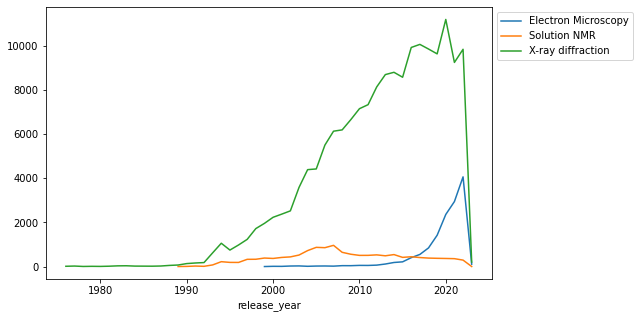

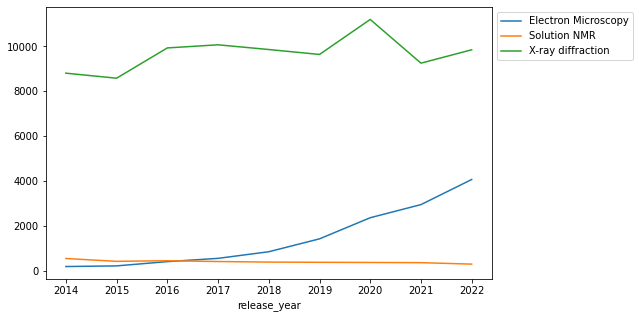

In [28]:
filter_column = 'experimental_method'
filter_list = ['Electron Microscopy', 'X-ray diffraction', 'Solution NMR']
pandas_plot_multi_groupby_filter(results, first_column_to_group_by='release_year', second_column_to_group_by='experimental_method', filter_column=filter_column, filter_list=filter_list)

pandas_plot_multi_groupby_filter(results, first_column_to_group_by='release_year', second_column_to_group_by='experimental_method', first_range_flag=True, first_lower=2014, first_upper=2022, filter_column=filter_column, filter_list=filter_list)

**X-ray resolution bins by year**

Create plot plotting X-ray resolution by year. Added filtering to remove minor method types

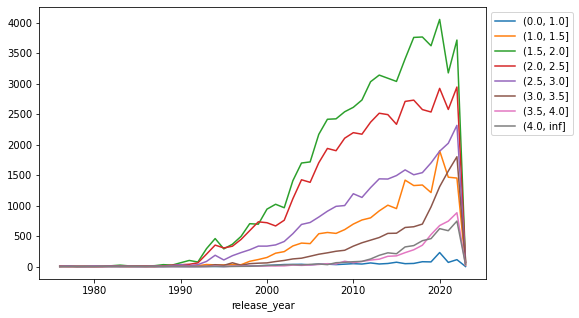

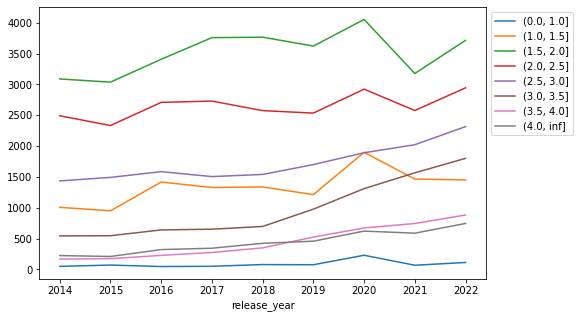

In [29]:
bin_cat = 'resolution range'
bin_range = [0, 1, 1.5, 2, 2.5, 3, 3.5, 4, float("inf")]
pandas_plot_multi_groupby_binned(results, first_column_to_group_by='release_year', second_column_to_group_by='resolution', bin_cat=bin_cat, bin_range=bin_range)
pandas_plot_multi_groupby_binned(results, first_column_to_group_by='release_year', second_column_to_group_by='resolution', first_range_flag=True, first_lower=2014, first_upper=2022, bin_cat=bin_cat, bin_range=bin_range)

**EM resolution bins by year**

Create plot plotting EM resolution by year. Added filtering to remove minor method types

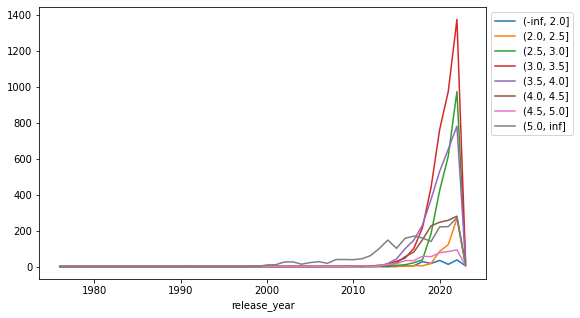

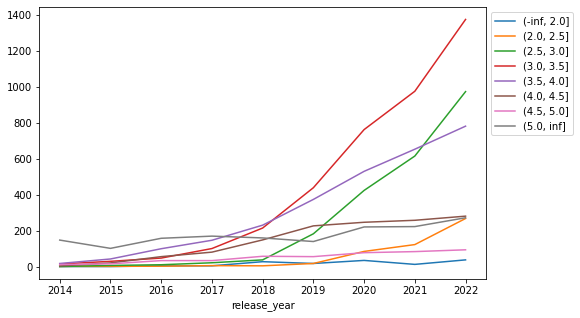

In [30]:
bin_cat = 'resolution range'
bin_range = [-float("inf"), 2, 2.5, 3, 3.5, 4, 4.5, 5, float("inf")]
pandas_plot_multi_groupby_binned(results, first_column_to_group_by='release_year', second_column_to_group_by='em_resolution', bin_cat=bin_cat, bin_range=bin_range)
pandas_plot_multi_groupby_binned(results, first_column_to_group_by='release_year', second_column_to_group_by='em_resolution', first_range_flag=True, first_lower=2014, first_upper=2022, bin_cat=bin_cat, bin_range=bin_range)

**Assembly molecular weight by year**

Create plot plotting Assembly molecular weight by year.

/usr/local/lib/python3.8/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))
/usr/local/lib/python3.8/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


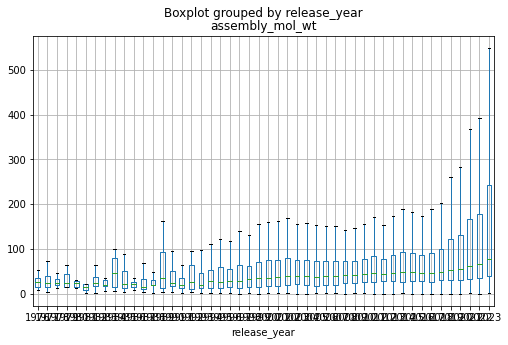

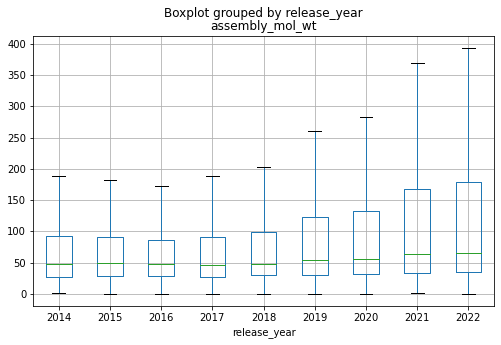

In [31]:
pandas_box_plot(results, first_column_to_group_by='release_year', second_column_to_group_by='assembly_mol_wt')
pandas_box_plot(results, first_column_to_group_by='release_year', second_column_to_group_by='assembly_mol_wt', first_range_flag=True, first_lower=2014, first_upper=2022)